<a href="https://colab.research.google.com/github/brendatransito/Tumor-Image-Classification/blob/main/02_cnn_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ResNet 50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Selección automática de dispositivo:
# - Usa GPU si está disponible (ideal para entrenamiento profundo)
# - Si no hay GPU, cae a CPU de forma segura
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
# ---------------------------------------------------------
# 1. Conectar Google Drive para acceder a archivos externos
# ---------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
# Esto monta Google Drive dentro del entorno de Colab en la ruta /content/drive.
# Te permite leer y escribir archivos directamente en tu Drive, lo cual es útil
# para guardar modelos, cargar scripts personalizados o manejar datasets.


# ---------------------------------------------------------
# 2. Agregar la ruta del proyecto al PATH de Python
# ---------------------------------------------------------
import sys
sys.path.append("/content/drive/MyDrive/Proyecto_PTI")
# Con esta línea, agregas la carpeta de tu proyecto al sistema de rutas
# que Python utiliza para buscar módulos. Así puedes importar prepare_dataset.py
# aunque esté almacenado en Google Drive y no en el directorio actual.


# ---------------------------------------------------------
# 3. Importar las funciones necesarias del módulo prepare_dataset
# ---------------------------------------------------------
from prepare_dataset import prepare_dataloaders_kaggle, load_clean_split_kaggle
# Aquí importas las funciones clave del pipeline:
#
# - prepare_dataloaders_kaggle:
#       Carga el dataset, lo limpia, elimina duplicados, aplica data augmentation
#       (si se activa), realiza el split reproducible 70/15/15 y devuelve los
#       dataloaders listos para usar en entrenamiento.
#
# - load_clean_split_kaggle:
#       Hace la misma limpieza y split, pero devuelve únicamente las rutas y
#       etiquetas para fines de exploración de datos (EDA), sin crear dataloaders.


Mounted at /content/drive


In [ ]:
import kagglehub
# Descargar automáticamente el dataset desde Kaggle mediante KaggleHub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download(
    'masoudnickparvar/brain-tumor-mri-dataset'
)

BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"
# Ruta donde Kaggle monta el dataset descargado (solo lectura)

from prepare_dataset import prepare_dataloaders_kaggle
# Importa la función que genera dataloaders limpios y reproducibles

# ----------------------------------------------------
# 1) Dataloaders con data augmentation activado
# ----------------------------------------------------
train_loader_aug, val_loader_aug, test_loader_aug, classes = prepare_dataloaders_kaggle(
    BASE_DIR, batch_size=32, augment_train=True
)
# train_loader_aug aplicará rotaciones, flips, jitter, etc.

# ----------------------------------------------------
# 2) Dataloaders sin data augmentation (baseline)
# ----------------------------------------------------
train_loader_noaug, val_loader_noaug, test_loader_noaug, _ = prepare_dataloaders_kaggle(
    BASE_DIR, batch_size=32, augment_train=False
)
# train_loader_noaug usa únicamente resize + normalize (sin transforms aleatorios)


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009

🔢 Mapeo clase → índice: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Usando DATA AUGMENTATION en entrenamiento
Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma 

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    # Modo entrenamiento: activa dropout y batchnorm
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()              # Reiniciar gradientes
        outputs = model(imgs)              # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Actualizar parámetros

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)     # Pérdida promedio del batch
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def eval_one_epoch(model, loader, criterion):
    # Modo evaluación: desactiva dropout y batchnorm en modo test
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():                   # No guardar gradientes
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)           # Forward sin retropropagación
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# -------------------------------------------------------------
# 1. Cargar modelo base ResNet-50 preentrenado en ImageNet
# -------------------------------------------------------------
# Se utiliza ResNet-50 como backbone porque es un modelo CNN robusto,
# ampliamente validado en visión computacional y que generaliza bien
# en datasets medianos como éste.
#
# El parámetro weights="IMAGENET1K_V2" carga los pesos entrenados
# en el conjunto ImageNet 1K, lo cual acelera la convergencia y
# mejora el rendimiento, especialmente cuando el dataset es pequeño.

model_aug = models.resnet50(weights="IMAGENET1K_V2")


# -------------------------------------------------------------
# 2. Modificar la capa fully-connected para 4 clases
# -------------------------------------------------------------
# ResNet-50 original tiene:
#   fc = Linear(2048 → 1000)
# para clasificar ImageNet.
#
# Aquí se reemplaza la capa final por un bloque que incluye:
#   - Dropout (para reducir sobreajuste)
#   - Linear(2048 → número de clases)
#
# num_features = dimensión de salida del último bloque convolucional.

num_features = model_aug.fc.in_features

model_aug.fc = nn.Sequential(
    nn.Dropout(p=0.5),            # Dropout fuerte (50%) para regularizar
    nn.Linear(num_features, len(classes))  # Nueva capa final para 4 clases
)

# Mover el modelo a GPU (si existe) o a CPU
model_aug = model_aug.to(device)


# -------------------------------------------------------------
# 3. Definir función de pérdida y optimizador
# -------------------------------------------------------------
# CrossEntropyLoss es el estándar para clasificación multiclase.
criterion = nn.CrossEntropyLoss()

# AdamW = Adam con regularización decente. Mejor que Adam normal.
optimizer_aug = optim.AdamW(
    model_aug.parameters(),
    lr=1e-4,              # LR moderado, recomendado para modelos preentrenados
    weight_decay=1e-5     # Regularización ligera para controlar sobreajuste
)


# -------------------------------------------------------------
# 4. Scheduler para reducir LR cuando la validación se estanca
# -------------------------------------------------------------
# ReduceLROnPlateau:
# - Observa la val_loss
# - Si no mejora por 3 epochs: reduce LR por factor de 0.1
# Esto estabiliza entrenamientos ruidosos o datasets pequeños.
scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_aug,
    mode='min',
    factor=0.1,
    patience=3
)


# -------------------------------------------------------------
# 5. Estructuras para guardar el historial y best model
# -------------------------------------------------------------
EPOCHS = 10

history_aug = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc": []
}

best_val_loss = float("inf")   # Para trackear el mejor modelo


# -------------------------------------------------------------
# 6. Bucle principal de entrenamiento (con augment)
# -------------------------------------------------------------
for epoch in range(EPOCHS):

    # Entrenamiento y validación por epoch
    train_loss, train_acc = train_one_epoch(model_aug, train_loader_aug, optimizer_aug, criterion)
    val_loss, val_acc     = eval_one_epoch(model_aug, val_loader_aug, criterion)

    # Registrar métricas
    history_aug["train_loss"].append(train_loss)
    history_aug["val_loss"].append(val_loss)
    history_aug["train_acc"].append(train_acc)
    history_aug["val_acc"].append(val_acc)

    # Actualizar learning rate si la val_loss no mejora
    scheduler_aug.step(val_loss)

    print(f"\n[Aug] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Val   Acc: {val_acc:.4f}")

    # Guardar el mejor modelo basado en validación
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            model_aug.state_dict(),
            "/content/drive/MyDrive/Proyecto_PTI/resnet50_aug_best.pth"
        )
        print(" ✔ Mejor modelo (Aug) guardado")



[Aug] Epoch 1/10
  Train Loss: 0.4898 | Train Acc: 0.8343
  Val   Loss: 0.1505   | Val   Acc: 0.9485
 Mejor modelo (Aug) guardado

[Aug] Epoch 2/10
  Train Loss: 0.1497 | Train Acc: 0.9497
  Val   Loss: 0.0907   | Val   Acc: 0.9673
 Mejor modelo (Aug) guardado

[Aug] Epoch 3/10
  Train Loss: 0.1101 | Train Acc: 0.9647
  Val   Loss: 0.0914   | Val   Acc: 0.9693

[Aug] Epoch 4/10
  Train Loss: 0.0911 | Train Acc: 0.9705
  Val   Loss: 0.0562   | Val   Acc: 0.9832
 Mejor modelo (Aug) guardado

[Aug] Epoch 5/10
  Train Loss: 0.0602 | Train Acc: 0.9798
  Val   Loss: 0.0354   | Val   Acc: 0.9861
 Mejor modelo (Aug) guardado

[Aug] Epoch 6/10
  Train Loss: 0.0480 | Train Acc: 0.9849
  Val   Loss: 0.0340   | Val   Acc: 0.9881
 Mejor modelo (Aug) guardado

[Aug] Epoch 7/10
  Train Loss: 0.0518 | Train Acc: 0.9845
  Val   Loss: 0.0817   | Val   Acc: 0.9693

[Aug] Epoch 8/10
  Train Loss: 0.0440 | Train Acc: 0.9849
  Val   Loss: 0.0485   | Val   Acc: 0.9851

[Aug] Epoch 9/10
  Train Loss: 0.0313 

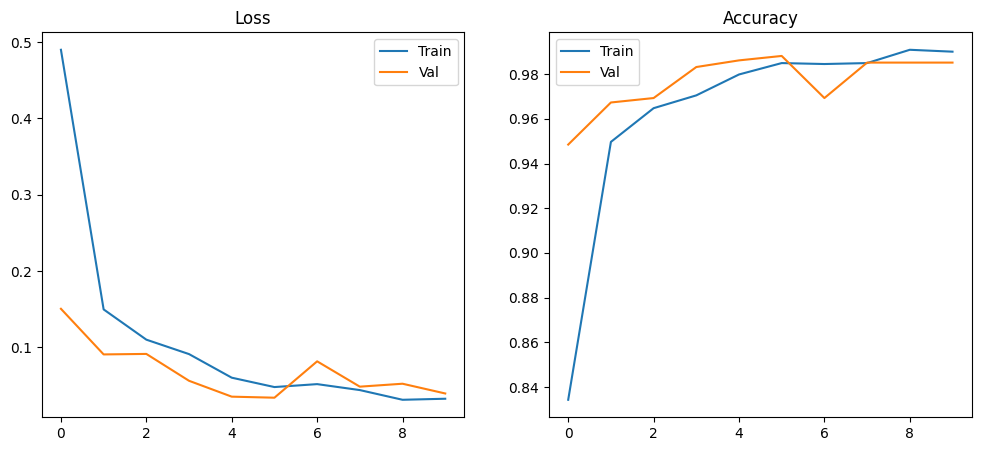

In [ ]:
plt.figure(figsize=(12,5))

# ----- Curva de pérdida -----
plt.subplot(1,2,1)
plt.plot(history_aug["train_loss"], label="Train")   # Pérdida en entrenamiento
plt.plot(history_aug["val_loss"], label="Val")       # Pérdida en validación
plt.title("Loss")
plt.legend()

# ----- Curva de exactitud -----
plt.subplot(1,2,2)
plt.plot(history_aug["train_acc"], label="Train")    # Accuracy en entrenamiento
plt.plot(history_aug["val_acc"], label="Val")        # Accuracy en validación
plt.title("Accuracy")
plt.legend()

plt.show()


In [ ]:
# -------------------------------------------------------------
# 1. Crear modelo base ResNet-50 SIN data augmentation
# -------------------------------------------------------------
# Se usa exactamente la misma arquitectura que el modelo con augment,
# pero los datos de entrenamiento NO pasan por transforms aleatorios.
# Esto permite comparar directamente generalización vs. sobreajuste.

model_noaug = models.resnet50(weights="IMAGENET1K_V2")   # Cargar modelo preentrenado
num_features = model_noaug.fc.in_features                # Tamaño de salida del backbone

# Reemplazar la capa totalmente conectada por Dropout + Linear
model_noaug.fc = nn.Sequential(
    nn.Dropout(p=0.5),                    # Dropout para mitigar overfitting incluso sin augmentation
    nn.Linear(num_features, len(classes)) # Nueva capa final para clasificación multiclase
)

# Enviar modelo a GPU o CPU según disponibilidad
model_noaug = model_noaug.to(device)


# -------------------------------------------------------------
# 2. Definir optimizador y scheduler
# -------------------------------------------------------------
optimizer_noaug = optim.AdamW(
    model_noaug.parameters(),
    lr=1e-4,
    weight_decay=1e-5                    # Regularización ligera
)

scheduler_noaug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_noaug,
    mode='min',
    factor=0.1,
    patience=3                           # Si val_loss no mejora en 3 epochs → bajar LR
)


# -------------------------------------------------------------
# 3. Estructuras para guardar métricas e identificar mejor modelo
# -------------------------------------------------------------
history_noaug = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc": []
}

best_val_loss_noaug = float("inf")        # Se usa para guardar el mejor checkpoint


# -------------------------------------------------------------
# 4. Entrenamiento principal por epochs
# -------------------------------------------------------------
for epoch in range(EPOCHS):

    # Entrenamiento y validación de una epoch completa
    train_loss, train_acc = train_one_epoch(model_noaug, train_loader_noaug, optimizer_noaug, criterion)
    val_loss, val_acc     = eval_one_epoch(model_noaug, val_loader_noaug, criterion)

    # Registrar métricas
    history_noaug["train_loss"].append(train_loss)
    history_noaug["val_loss"].append(val_loss)
    history_noaug["train_acc"].append(train_acc)
    history_noaug["val_acc"].append(val_acc)

    # Actualizar LR si es necesario
    scheduler_noaug.step(val_loss)

    # Mostrar progreso de entrenamiento
    print(f"\n[NoAug] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Val   Acc: {val_acc:.4f}")

    # Guardar mejor modelo basado en val_loss
    if val_loss < best_val_loss_noaug:
        best_val_loss_noaug = val_loss
        torch.save(
            model_noaug.state_dict(),
            "/content/drive/MyDrive/Proyecto_PTI/resnet50_noaug_best.pth"
        )
        print("  ✔ Mejor modelo (NoAug) guardado")



[NoAug] Epoch 1/10
  Train Loss: 0.4120 | Train Acc: 0.8668
  Val   Loss: 0.1015   | Val   Acc: 0.9663
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 2/10
  Train Loss: 0.0850 | Train Acc: 0.9732
  Val   Loss: 0.0870   | Val   Acc: 0.9732
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 3/10
  Train Loss: 0.0382 | Train Acc: 0.9881
  Val   Loss: 0.0434   | Val   Acc: 0.9871
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 4/10
  Train Loss: 0.0220 | Train Acc: 0.9958
  Val   Loss: 0.0544   | Val   Acc: 0.9861

[NoAug] Epoch 5/10
  Train Loss: 0.0176 | Train Acc: 0.9970
  Val   Loss: 0.0436   | Val   Acc: 0.9832

[NoAug] Epoch 6/10
  Train Loss: 0.0335 | Train Acc: 0.9896
  Val   Loss: 0.1095   | Val   Acc: 0.9713

[NoAug] Epoch 7/10
  Train Loss: 0.0167 | Train Acc: 0.9947
  Val   Loss: 0.0449   | Val   Acc: 0.9861

[NoAug] Epoch 8/10
  Train Loss: 0.0133 | Train Acc: 0.9964
  Val   Loss: 0.0347   | Val   Acc: 0.9861
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 9/10
  Train Loss: 0.0048

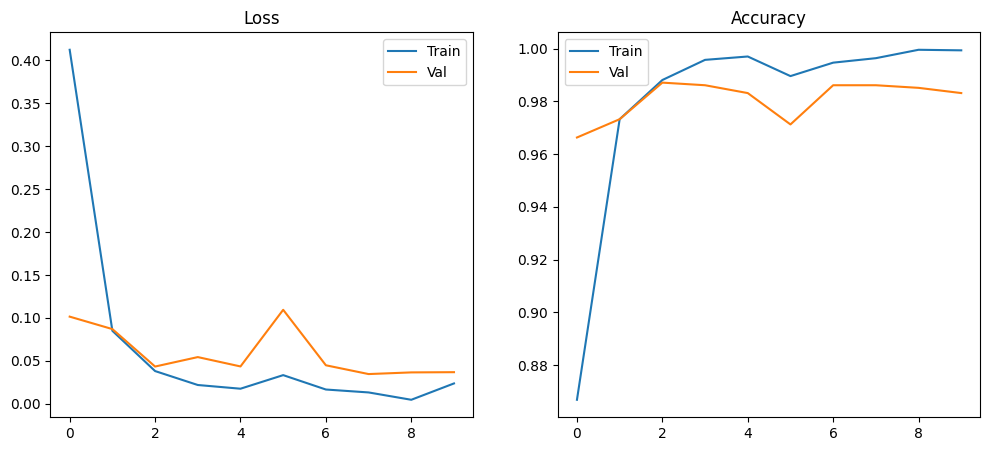

In [ ]:
plt.figure(figsize=(12,5))

# ----- Curva de pérdida -----
plt.subplot(1,2,1)
plt.plot(history_noaug["train_loss"], label="Train")  # Pérdida en entrenamiento
plt.plot(history_noaug["val_loss"], label="Val")      # Pérdida en validación
plt.title("Loss")
plt.legend()

# ----- Curva de exactitud -----
plt.subplot(1,2,2)
plt.plot(history_noaug["train_acc"], label="Train")   # Accuracy en entrenamiento
plt.plot(history_noaug["val_acc"], label="Val")       # Accuracy en validación
plt.title("Accuracy")
plt.legend()

plt.show()


In [ ]:
# -------------------------------
# Evaluar modelo ENTRENADO con augment
# -------------------------------
model_aug.load_state_dict(torch.load("/content/drive/MyDrive/Proyecto_PTI/resnet50_aug_best.pth"))
# Cargar los pesos del mejor modelo basado en validación

test_loss_aug, test_acc_aug = eval_one_epoch(model_aug, test_loader_aug, criterion)
# Evaluar en el conjunto de prueba (test)

# -------------------------------
# Evaluar modelo ENTRENADO sin augment
# -------------------------------
model_noaug.load_state_dict(torch.load("/content/drive/MyDrive/Proyecto_PTI/resnet50_noaug_best.pth"))
# Cargar pesos del mejor modelo sin augmentation

test_loss_noaug, test_acc_noaug = eval_one_epoch(model_noaug, test_loader_noaug, criterion)
# Evaluar en test

# -------------------------------
# Mostrar resultados comparativos
# -------------------------------
print(f"Test (Aug)   -> Loss: {test_loss_aug:.4f} | Acc: {test_acc_aug:.4f}")
print(f"Test (NoAug) -> Loss: {test_loss_noaug:.4f} | Acc: {test_acc_noaug:.4f}")


Test (Aug)   -> Loss: 0.0423 | Acc: 0.9802
Test (NoAug) -> Loss: 0.0313 | Acc: 0.9881


In [ ]:
model_aug.eval()               # Modo evaluación: desactiva dropout/batchnorm
y_true = []
y_pred = []

with torch.no_grad():          # No se calculan gradientes durante inferencia
    for imgs, labels in test_loader_aug:
        imgs = imgs.to(device)

        output = model_aug(imgs)               # Forward pass
        preds = output.argmax(1).cpu().numpy() # Clase con mayor probabilidad

        y_true.extend(labels.numpy())          # Etiquetas reales
        y_pred.extend(preds)                   # Predicciones

# Reporte detallado de métricas para las 4 clases
print("Reporte de clasificación con data Augmentation")
print(classification_report(y_true, y_pred, target_names=classes))


Reporte de clasificación con data Augmentation
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       243
  meningioma       0.94      1.00      0.97       246
     notumor       1.00      0.98      0.99       259
   pituitary       0.99      0.99      0.99       261

    accuracy                           0.98      1009
   macro avg       0.98      0.98      0.98      1009
weighted avg       0.98      0.98      0.98      1009



In [ ]:
model_noaug.eval()             # Modo evaluación (desactiva dropout)
y_true = []
y_pred = []

with torch.no_grad():          # No calcular gradientes en inferencia
    for imgs, labels in test_loader_noaug:
        imgs = imgs.to(device)

        output = model_noaug(imgs)              # Forward pass
        preds = output.argmax(1).cpu().numpy()  # Predicción final por clase

        y_true.extend(labels.numpy())           # Etiquetas reales
        y_pred.extend(preds)                    # Etiquetas predichas

# Reporte de métricas por clase (precision, recall, F1)
print("Reporte de clasificación sin data Augmentation")
print(classification_report(y_true, y_pred, target_names=classes))


Reporte de clasificación sin data Augmentation
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       243
  meningioma       0.98      0.99      0.98       246
     notumor       1.00      0.98      0.99       259
   pituitary       0.99      1.00      0.99       261

    accuracy                           0.99      1009
   macro avg       0.99      0.99      0.99      1009
weighted avg       0.99      0.99      0.99      1009



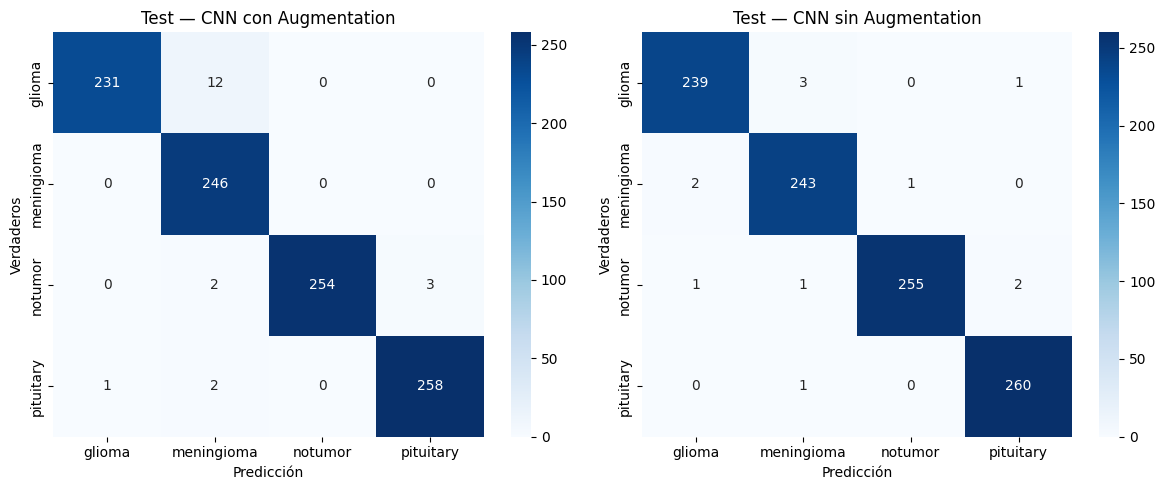

In [ ]:
def get_preds(model, loader):
    # Genera predicciones y etiquetas reales para un DataLoader
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():                   # Inferencia sin gradientes
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs)               # Forward pass
            preds = out.argmax(1).cpu().numpy()  # Clase predicha

            y_true.extend(labels.numpy())        # Etiquetas reales
            y_pred.extend(preds)                 # Etiquetas predichas

    return np.array(y_true), np.array(y_pred)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# Matriz de confusión — Modelo con augmentation
# ---------------------------
y_true_aug, y_pred_aug = get_preds(model_aug, test_loader_aug)
cm_aug = confusion_matrix(y_true_aug, y_pred_aug).astype(int)


# ---------------------------
# Matriz de confusión — Modelo sin augmentation
# ---------------------------
y_true_noaug, y_pred_noaug = get_preds(model_noaug, test_loader_noaug)
cm_noaug = confusion_matrix(y_true_noaug, y_pred_noaug).astype(int)


plt.figure(figsize=(12,5))

# ----- Gráfico AUGMENTATION -----
plt.subplot(1,2,1)
sns.heatmap(
    cm_aug, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes, yticklabels=classes
)
plt.title("Test — CNN con Augmentation")
plt.xlabel("Predicción"); plt.ylabel("Verdaderos")

# ----- Gráfico SIN AUGMENTATION -----
plt.subplot(1,2,2)
sns.heatmap(
    cm_noaug, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes, yticklabels=classes
)
plt.title("Test — CNN sin Augmentation")
plt.xlabel("Predicción"); plt.ylabel("Verdaderos")

plt.tight_layout()
plt.show()
